In [ ]:
import numpy as np
import pandas as pd
import pickle
import plotly.express as px

### Import Data 
Move to Colab instance for faster training and avoid quota issues with Google Drive

In [ ]:
from google.colab import drive

In [ ]:
# Connect to Google Drive
drive.mount('/content/gdrive')
google_dir = '/content/gdrive/MyDrive/ANLP'

Mounted at /content/gdrive


In [ ]:
# Copy data file to Colab instance to avoid quota issues with Google Drive
# https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?resource=download (673.7 MB)
!cp "/content/gdrive/MyDrive/ANLP/Reviews.csv" "/content/"

In [ ]:
# Load and check data
data = pd.read_csv("/content/Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Data Prep
Create target variable and perform NLP on dataset to prep for model training.

In [ ]:
# Filter out reviews with helpfulness votes
helpful_df = data.loc[data['HelpfulnessDenominator'] >= 10].copy()

# Create Target Variable
helpful_df['helpful_score'] = helpful_df['HelpfulnessNumerator'] / helpful_df['HelpfulnessDenominator']

In [ ]:
# Convert to label for classification
helpful_df['helpful_score'] = np.where(helpful_df['helpful_score'] >= 0.8, 1, 0)
helpful_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpful_score
32,33,B001EO5QW8,AOVROBZ8BNTP7,S. Potter,19,19,4,1163376000,Best of the Instant Oatmeals,McCann's Instant Oatmeal is great if you must ...,1
33,34,B001EO5QW8,A3PMM0NFVEJGK9,"Megan ""Bad at Nicknames""",13,13,4,1166313600,Good Instant,This is a good instant oatmeal from the best o...,1
82,83,B003ZFRKGO,A2VOZX7YBT0D6D,"Johnnycakes ""Johnnycakes""",15,15,5,1325635200,Forget Molecular Gastronomy - this stuff rocke...,I know the product title says Molecular Gastro...,1
158,159,B000ITVLE2,A3NID9D9WMIV01,"Louie Arrighi ""Lou da Joo""",17,19,5,1260057600,tastes very fresh,"<span class=""tiny""> Length:: 0:26 Mins<br /><b...",1
213,214,B0009XLVGA,A1NHQNQ3TVXTZF,"Desert Girl ""chrissylovesherhusband""",3,10,1,1220227200,CHANGED FORMULA MAKES CATS SICK!!!!,"As with canidae, Felidae has also changed thei...",0


In [ ]:
import spacy
import spacy.cli

In [ ]:
# Using the large model over the standard version to get vectors. Requires additional install.
spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
# Apply spacy's nlp function to text. 
# Run time: approx. 15mins 
helpful_df['nlp'] = helpful_df['Text'].apply(nlp)

In [ ]:
# Calculate static features

In [ ]:
# Remove unused columns to free up memory 
helpful_df = helpful_df[['Text', 'helpful_score', 'nlp']]

# Counting stats
helpful_df['sentences'] = helpful_df['nlp'].apply(lambda x: [sent for sent in x.sents])
helpful_df['num_sent'] = helpful_df['sentences'].apply(len)
helpful_df['max_sent_len'] = helpful_df['sentences'].apply(lambda x: max([len(sent) for sent in x]))
helpful_df['mean_sent_len'] = helpful_df['sentences'].apply(lambda x: np.mean([len(sent) for sent in x]))

# Entity names
helpful_df['ner'] = helpful_df['nlp'].apply(lambda x: [x for x in x.ents])
helpful_df['ner_len'] = helpful_df['ner'].apply(len)

In [ ]:
helpful_df[['num_sent', 'max_sent_len', 'mean_sent_len', 'ner_len']].to_csv('/content/gdrive/MyDrive/models/summary_stats.csv')

Apply text cleaning and reprocess nlp function

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.9 MB/s eta 0:00:00


In [ ]:
import contractions

In [ ]:
# Adjust contractions such as can't, don't, etc.
helpful_df['Text'] = helpful_df['Text'].apply(contractions.fix)

# Remove html tags
helpful_df['Text'] = helpful_df['Text'].str.replace(r'<[^>]+>', '', regex=True)

# Remove numbers
helpful_df['Text'] = helpful_df['Text'].str.replace(r'[0-9]+', '', regex=True)

# Remove punctuation
helpful_df['Text'] = helpful_df['Text'].str.replace(r'[^\w\s]', '', regex=True)

# Lower case
helpful_df['Text'] = helpful_df['Text'].str.lower()

32        mccanns instant oatmeal is great if you must h...
33        this is a good instant oatmeal from the best o...
82        i know the product title says molecular gastro...
158        length  minsthe expiration date is  months fr...
213       as with canidae felidae has also changed their...
                                ...                        
568253    i bought them at shoprite at  for a box of  it...
568274    i have tried this in many different recipes al...
568275    stevia in the raw contains saccharine which is...
568324    fiber one bars actually do not have real fiber...
568436    in the past i would have to buy a large quanti...
Name: Text, Length: 24982, dtype: object

In [ ]:
# lemmatise and remove stop words, then reprocess new column
# Run time: approx. 8mins
helpful_df['Text'] = helpful_df['nlp'].apply(lambda x: [y.lemma_ for y in x if not y.is_stop])
helpful_df['Text'] = helpful_df['Text'].apply(' '.join)
helpful_df['nlp'] = helpful_df['Text'].apply(nlp)

In [ ]:
# Create dataframe of vectorised text.
vectors = helpful_df['nlp'].apply(lambda x: x.vector)
vec_df = vectors.apply(pd.Series)
vec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
32,-0.256815,0.060683,-2.069701,0.757334,1.099756,-1.270127,0.917903,2.407686,-2.804638,0.732963,...,0.268859,-1.600913,1.279289,-1.303695,-1.816494,-1.120166,0.474976,0.028845,-1.348039,0.142843
33,-0.465704,-0.733475,-1.507612,1.216777,1.740806,-1.838485,1.055258,2.889776,-2.573060,0.827688,...,0.284785,-1.819242,1.286407,-1.888366,-1.710316,-0.563213,1.178225,0.411050,-1.677812,0.272364
82,0.141113,-0.157288,-1.793722,0.701365,0.728796,-1.902817,1.025491,2.490789,-2.810584,1.188342,...,0.584325,-1.389941,1.073023,-1.305877,-2.483030,-1.378824,1.083406,0.712139,-1.522426,0.211829
158,-0.702020,0.134103,-1.572412,-0.338322,1.705769,-0.515772,1.138944,2.372710,-2.839762,-0.145853,...,0.864681,-0.538355,0.685544,-0.185533,-1.911671,0.050855,1.822124,-1.355930,-1.836877,-0.296239
213,0.537929,0.563375,-2.533133,-1.176048,0.799180,-0.355862,0.083754,1.993065,-1.910131,1.347824,...,1.342178,-0.991235,1.538022,-1.189864,-2.087963,-1.670366,-0.491525,0.559250,-2.313208,1.092412


Save down processed file to avoid retraining

In [ ]:
# Warning: NLP processed dataframe size is approx. 1.4G 
with open('/content/gdrive/MyDrive/models/nlp_df_pro.pickle', 'wb') as handle:
    pickle.dump(helpful_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/gdrive/MyDrive/models/vectors_pro.pickle', 'wb') as handle:
    pickle.dump(vec_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/gdrive/MyDrive/models/nlp_df_pro.pickle', 'rb') as handle:
    helpful_df = pickle.load(handle)

with open('/content/gdrive/MyDrive/models/vectors_pro.pickle', 'rb') as handle:
    vec_df = pickle.load(handle)

### Modeling
Prepare training data and configure TPU for training. Requires Colab Pro, bidirectional models are too large to run on CPU (+10hrs run time). 

In [ ]:
# Set up TPU for training
import tensorflow as tf

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.46.212.178:8470']


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split data
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(vec_df, helpful_df['helpful_score'], test_size=test_size/(1 - test_size), random_state=99)

X_train, X_val, y_train, y_val = train_test_split(vec_df, helpful_df['helpful_score'], test_size=test_size/(1 - test_size), random_state=99)

Bidirectional GRU Model

In [ ]:
from tensorflow.keras.layers import add, Bidirectional, concatenate, Dense, Dropout, GlobalAveragePooling1D, GRU, Input
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.metrics import confusion_matrix

In [ ]:
# Create BiGRU model

# Parameters
optimizer_bigru = tf.keras.optimizers.Adam(learning_rate=0.001)
early_stop_bigru = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, restore_best_weights=True)
input_shape = (X_train.shape[1], 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'AUC']

# Architecture
with tpu_strategy.scope():
  layers = [Bidirectional(GRU(128, input_shape=input_shape, activation='relu', return_sequences=True), input_shape=input_shape),
            Dropout(0.2),
            Bidirectional(GRU(128, activation='relu')),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')]
  model_bigru = Sequential(layers)
  model_bigru.compile(loss='binary_crossentropy', optimizer=optimizer_bigru, metrics=metrics)
model_bigru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 300, 256)         100608    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              296448    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [ ]:
# Fit Model 
# Runtime approx. 18mins with Google Colab TPU. Do not run on CPU. 
# Alternatively, load existing model in cell below
history_bigru = model_bigru.fit(X_train, y_train, 
                                validation_data=(X_val, y_val), 
                                epochs=100, batch_size=64, 
                                callbacks=[early_stop_bigru])


Epoch 1/100
347/347 [==============================] - 61s 135ms/step - loss: 0.6428 - Accuracy: 0.6531 - precision: 0.6541 - recall: 0.9957 - auc: 0.5537 - val_loss: 0.6235 - val_Accuracy: 0.6639 - val_precision: 0.6616 - val_recall: 0.9967 - val_auc: 0.6775
Epoch 2/100
347/347 [==============================] - 40s 116ms/step - loss: 0.6022 - Accuracy: 0.6840 - precision: 0.6986 - recall: 0.9084 - auc: 0.6758 - val_loss: 0.5900 - val_Accuracy: 0.6837 - val_precision: 0.6901 - val_recall: 0.9384 - val_auc: 0.7104
Epoch 3/100
347/347 [==============================] - 40s 116ms/step - loss: 0.5877 - Accuracy: 0.6931 - precision: 0.7139 - recall: 0.8851 - auc: 0.7007 - val_loss: 0.5780 - val_Accuracy: 0.6938 - val_precision: 0.7347 - val_recall: 0.8333 - val_auc: 0.7204
Epoch 4/100
347/347 [==============================] - 41s 118ms/step - loss: 0.5800 - Accuracy: 0.6974 - precision: 0.7207 - recall: 0.8768 - auc: 0.7129 - val_loss: 0.5729 - val_Accuracy: 0.6952 - val_precision: 0.7450

In [ ]:
# Save model
model_bigru.save('/content/gdrive/MyDrive/models/anlp_bi_class_extended.h5')

# Save history
np.save('/content/gdrive/MyDrive/models/anlp_bi_class_extended.npy', history_bigru)

In [ ]:
# Optional: Load Existing Model
model_bigru = load_model('/content/gdrive/MyDrive/models/anlp_bi_class_extended.h5')

Evaluation

In [ ]:
# Out of sample evaluation and predictions
results = model_bigru.evaluate(X_test, y_test, batch_size=64)
y_pred = model_bigru.predict(X_test)
y_pred = np.round(y_pred).astype(int)

87/87 [==============================] - 6s 48ms/step


In [ ]:
def plot_confusion_matrix(matrix):
  fig = px.imshow(matrix, 
                  color_continuous_scale='RdBu_r', text_auto='.2f',
                  labels={'x': 'Predicted Value', 'y': 'True Value'})
  tickvals = {'tickvals': ['', '0', '', '1', '']}
  fig.update_layout(xaxis=tickvals, yaxis=tickvals)
  fig.show()

In [ ]:
# Show confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize='pred')
plot_confusion_matrix(cf_matrix)

In [ ]:
def calc_f1_score(precision, recall):
  f1 = 2 * (precision * recall) / (precision + recall)
  print('F1 Score: {:.2f}%'.format(f1 * 100))

  return f1

In [ ]:
# Use F1 score given imbalanced dataset
f1_score = calc_f1_score(results[2], results[3])

F1 Score: 81.54%


Check if Pooling layers are useful

In [ ]:
# Create BiGRU model

# Parameters
optimizer_adj = tf.keras.optimizers.Adam(learning_rate=0.001)
early_stop_adj = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, restore_best_weights=True)
input_shape = (X_train.shape[1], 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'AUC']

# Architecture
with tpu_strategy.scope():
  layers = [Bidirectional(GRU(128, input_shape=input_shape, activation='relu', return_sequences=True), input_shape=input_shape),
            Dropout(0.2),
            Bidirectional(GRU(128, activation='relu', return_sequences=True)),
            Dropout(0.2),
            GlobalAveragePooling1D(),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')]
  model_adj = Sequential(layers)
  model_adj.compile(loss='binary_crossentropy', optimizer=optimizer_adj, metrics=metrics)
model_adj.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 300, 256)         100608    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 300, 256)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 300, 256)         296448    
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 300, 256)          0         
                                                                 
 global_average_pooling1d_1   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                      

In [ ]:
history_adj = model_adj.fit(X_train, y_train, 
                            validation_data=(X_val, y_val), 
                            epochs=100, batch_size=64, 
                            callbacks=[early_stop_bigru])

Epoch 1/100
347/347 [==============================] - 61s 130ms/step - loss: 0.6508 - Accuracy: 0.6532 - precision: 0.6538 - recall: 0.9975 - auc: 0.4934 - val_loss: 0.6439 - val_Accuracy: 0.6549 - val_precision: 0.6549 - val_recall: 1.0000 - val_auc: 0.5320
Epoch 2/100
347/347 [==============================] - 41s 117ms/step - loss: 0.6461 - Accuracy: 0.6536 - precision: 0.6536 - recall: 1.0000 - auc: 0.5104 - val_loss: 0.6417 - val_Accuracy: 0.6549 - val_precision: 0.6549 - val_recall: 1.0000 - val_auc: 0.5427
Epoch 3/100
347/347 [==============================] - 41s 117ms/step - loss: 0.6447 - Accuracy: 0.6545 - precision: 0.6545 - recall: 0.9986 - auc: 0.5264 - val_loss: 0.6397 - val_Accuracy: 0.6581 - val_precision: 0.6585 - val_recall: 0.9928 - val_auc: 0.5423
Epoch 4/100
347/347 [==============================] - 40s 117ms/step - loss: 0.6447 - Accuracy: 0.6552 - precision: 0.6562 - recall: 0.9927 - auc: 0.5359 - val_loss: 0.6410 - val_Accuracy: 0.6560 - val_precision: 0.6558

In [ ]:
# Evaluation
results_adj = model_adj.evaluate(X_test, y_test, batch_size=64)
y_pred_adj = model_adj.predict(X_test)
y_pred_adj = np.round(y_pred_adj).astype(int)

# Confusion matrix
cf_matrix_adj = confusion_matrix(y_test, y_pred_adj, normalize='pred')
plot_confusion_matrix(cf_matrix_adj)

# F1
f1_score_adj = calc_f1_score(results_adj[2], results_adj[3])

87/87 [==============================] - 5s 47ms/step


F1 Score: 77.37%


Try merging static features with sequential model

In [ ]:
helpful_df[['num_sent', 'max_sent_len', 'mean_sent_len', 'ner_len']]

,num_sent,max_sent_len,mean_sent_len,ner_len
32,11,47,21.090909,8
33,5,37,20.800000,3
82,25,47,20.440000,4
158,4,72,27.250000,5
213,21,49,19.523810,10
...,...,...,...,...
568253,8,52,31.875000,19
568274,11,61,21.818182,3
568275,9,57,33.222222,11
568324,6,32,16.666667,0


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
stats = scaler.fit_transform(helpful_df[['num_sent', 'max_sent_len', 'mean_sent_len', 'ner_len']])

In [ ]:
stats_df = pd.DataFrame(data=stats, index=helpful_df.index, columns=['num_sent', 'max_sent_len', 'mean_sent_len', 'ner_len'])
stats_df.head() 

,num_sent,max_sent_len,mean_sent_len,ner_len
32,0.305332,0.533664,0.220676,0.249250
33,-0.413990,0.035300,0.183449,-0.360715
82,1.983749,0.533664,0.137380,-0.238722
158,-0.533876,1.779573,1.008844,-0.116729
213,1.504202,0.633336,0.020137,0.493236


In [ ]:
# Create stacked model

# Parameters
optimizer_stack = tf.keras.optimizers.Adam(learning_rate=0.001)
early_stop_stack = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, restore_best_weights=True)
input_shape = (X_train.shape[1], 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'AUC']

# Architecture
with tpu_strategy.scope():
  stats_input = Input(shape=(stats.shape[1], ), name='Static Input')
  stats_model = Dense(32, activation='relu', name='Layer1-32')(stats_input)
  stats_model = Dropout(0.2, name='Dropout1-20')(stats_model)
  stats_model = Dense(32, activation='relu', name='Layer2-32')(stats_model)

  text_input = Input(shape=input_shape, name='Embeddings Input')
  text_model = Bidirectional(GRU(128, activation='relu', return_sequences=True, name='Layer3-128'), name='Bidirectional1')(text_input)
  text_model = Dropout(0.2, name='Dropout2-20')(text_model)
  text_model = Bidirectional(GRU(128, activation='relu', name='Layer4-128'), name='Bidirectional2')(text_model)

  merged_model = concatenate([stats_model, text_model], axis=1, name='Merged')
  merged_pred = Dropout(0.2, name='Dropout3-20')(merged_model)
  merged_pred = Dense(32, activation='relu', name='Layer5-32')(merged_pred)
  merged_pred = Dropout(0.2, name='Dropout4-20')(merged_pred)
  merged_pred = Dense(1, activation='sigmoid', name='Prediction')(merged_pred)

  final_model = Model(inputs=[stats_input, text_input], outputs=[merged_pred])
  final_model.compile(loss='binary_crossentropy', optimizer=optimizer_stack, metrics=metrics)

final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Static Input (InputLayer)      [(None, 4)]          0           []                               
                                                                                                  
 Embeddings Input (InputLayer)  [(None, 300, 1)]     0           []                               
                                                                                                  
 Layer1-32 (Dense)              (None, 32)           160         ['Static Input[0][0]']           
                                                                                                  
 Bidirectional1 (Bidirectional)  (None, 300, 256)    100608      ['Embeddings Input[0][0]']       
                                                                                              

In [ ]:
# Train-test split of stats data to line up with existing vectorised data
X_stats_train = stats_df.loc[X_train.index]
X_stats_val = stats_df.loc[X_val.index]
X_stats_test = stats_df.loc[X_test.index]

In [ ]:
# Fit model
# Run-time approx. 27 mins
history_final = final_model.fit([X_stats_train, X_train], y_train, 
                                validation_data=([X_stats_val, X_val], y_val), 
                                epochs=100, batch_size=64, 
                                callbacks=[early_stop_stack])

Epoch 1/100
347/347 [==============================] - 61s 135ms/step - loss: 0.6313 - Accuracy: 0.6581 - precision: 0.6654 - recall: 0.9590 - auc: 0.6022 - val_loss: 0.6046 - val_Accuracy: 0.6826 - val_precision: 0.6964 - val_recall: 0.9136 - val_auc: 0.6686
Epoch 2/100
347/347 [==============================] - 42s 121ms/step - loss: 0.5973 - Accuracy: 0.6893 - precision: 0.7065 - recall: 0.8975 - auc: 0.6823 - val_loss: 0.5842 - val_Accuracy: 0.6855 - val_precision: 0.6970 - val_recall: 0.9197 - val_auc: 0.7107
Epoch 3/100
347/347 [==============================] - 41s 119ms/step - loss: 0.5840 - Accuracy: 0.6969 - precision: 0.7184 - recall: 0.8820 - auc: 0.7075 - val_loss: 0.5747 - val_Accuracy: 0.6999 - val_precision: 0.7159 - val_recall: 0.8982 - val_auc: 0.7213
Epoch 4/100
347/347 [==============================] - 41s 119ms/step - loss: 0.5761 - Accuracy: 0.7013 - precision: 0.7253 - recall: 0.8740 - auc: 0.7182 - val_loss: 0.5689 - val_Accuracy: 0.6978 - val_precision: 0.7113

In [ ]:
# Evaluation
results_stack = final_model.evaluate([X_stats_test, X_test], y_test, batch_size=64)
y_pred_stack = final_model.predict([X_stats_test, X_test])
y_pred_stack = np.round(y_pred_stack).astype(int)

# Confusion matrix
cf_matrix_stack = confusion_matrix(y_test, y_pred_stack, normalize='pred')
plot_confusion_matrix(cf_matrix_stack)

# F1
f1_score_stack = calc_f1_score(results_stack[2], results_stack[3])

87/87 [==============================] - 7s 50ms/step


F1 Score: 85.04%


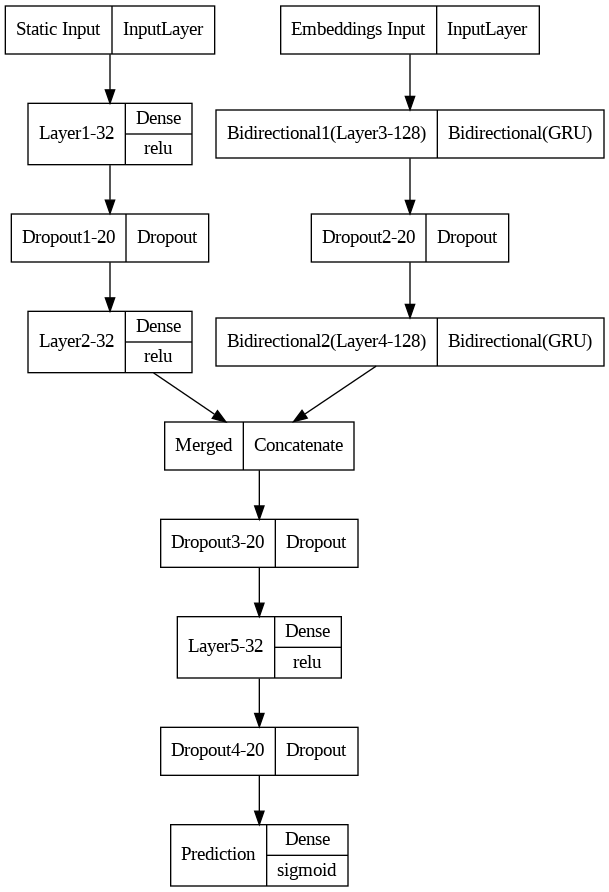

In [ ]:
tf.keras.utils.plot_model(final_model, expand_nested=True, show_layer_activations=True)

In [ ]:
from textblob import TextBlob

In [ ]:
sentiment = [TextBlob(x).sentiment for x in helpful_df['Text']]

In [ ]:
helpful_df['polarity'] = [x[0] for x in sentiment]
helpful_df['subjectivity'] = [x[1] for x in sentiment]

In [ ]:
scaler_2 = StandardScaler()
stats_2 = scaler.fit_transform(helpful_df[['num_sent', 'max_sent_len', 'mean_sent_len', 'ner_len', 'polarity', 'subjectivity']])

In [ ]:
# Train-test split of stats data to line up with existing vectorised data
stats_df2 = pd.DataFrame(data=stats_2, index=helpful_df.index, 
                         columns=['num_sent', 'max_sent_len', 'mean_sent_len', 'ner_len', 'polarity', 'subjectivity'])

X_stats_train2 = stats_df2.loc[X_train.index]
X_stats_val2 = stats_df2.loc[X_val.index]
X_stats_test2 = stats_df2.loc[X_test.index]

In [ ]:
# Create stacked model

# Parameters
optimizer_stack2 = tf.keras.optimizers.Adam(learning_rate=0.001)
early_stop_stack2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, restore_best_weights=True)
input_shape = (X_train.shape[1], 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'AUC']

# Architecture
with tpu_strategy.scope():
  stats_input2 = Input(shape=(stats_2.shape[1], ))
  stats_model2 = Dense(32, activation='relu')(stats_input2)
  stats_model2 = Dropout(0.2)(stats_model2)
  stats_model2 = Dense(32, activation='relu')(stats_model2)

  text_input2 = Input(shape=input_shape)
  text_model2 = Bidirectional(GRU(128, activation='relu', return_sequences=True))(text_input2)
  text_model2 = Dropout(0.2)(text_model2)
  text_model2 = Bidirectional(GRU(128, activation='relu'))(text_model2)

  merged_model2 = concatenate([stats_model2, text_model2], axis=1)
  merged_pred2 = Dropout(0.2)(merged_model2)
  merged_pred2 = Dense(32, activation='relu')(merged_pred2)
  merged_pred2 = Dropout(0.2)(merged_pred2)
  merged_pred2 = Dense(1, activation='sigmoid')(merged_pred2)

  final_model2 = Model(inputs=[stats_input2, text_input2], outputs=[merged_pred2])
  final_model2.compile(loss='binary_crossentropy', optimizer=optimizer_stack2, metrics=metrics)

final_model2.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 6)]          0           []                               
                                                                                                  
 input_54 (InputLayer)          [(None, 300, 1)]     0           []                               
                                                                                                  
 dense_61 (Dense)               (None, 32)           224         ['input_53[0][0]']               
                                                                                                  
 bidirectional_44 (Bidirectiona  (None, 300, 256)    100608      ['input_54[0][0]']               
 l)                                                                                        

In [ ]:
# Fit model
# Run-time approx. 27 mins
history_final2 = final_model2.fit([X_stats_train2, X_train], y_train, 
                                validation_data=([X_stats_val2, X_val], y_val), 
                                epochs=100, batch_size=64, 
                                callbacks=[early_stop_stack2])

Epoch 1/100
347/347 [==============================] - 63s 134ms/step - loss: 0.6033 - Accuracy: 0.6858 - precision: 0.6991 - recall: 0.9115 - auc: 0.6696 - val_loss: 0.5764 - val_Accuracy: 0.7061 - val_precision: 0.7167 - val_recall: 0.9114 - val_auc: 0.7202
Epoch 2/100
347/347 [==============================] - 41s 118ms/step - loss: 0.5783 - Accuracy: 0.7048 - precision: 0.7263 - recall: 0.8798 - auc: 0.7155 - val_loss: 0.5605 - val_Accuracy: 0.7143 - val_precision: 0.7369 - val_recall: 0.8768 - val_auc: 0.7418
Epoch 3/100
347/347 [==============================] - 41s 118ms/step - loss: 0.5656 - Accuracy: 0.7114 - precision: 0.7396 - recall: 0.8620 - auc: 0.7355 - val_loss: 0.5602 - val_Accuracy: 0.7129 - val_precision: 0.7236 - val_recall: 0.9087 - val_auc: 0.7472
Epoch 4/100
347/347 [==============================] - 41s 118ms/step - loss: 0.5598 - Accuracy: 0.7164 - precision: 0.7458 - recall: 0.8588 - auc: 0.7429 - val_loss: 0.5507 - val_Accuracy: 0.7187 - val_precision: 0.7473

In [ ]:
# Evaluation
results_stack2 = final_model2.evaluate([X_stats_test2, X_test], y_test, batch_size=64)
y_pred_stack2 = final_model2.predict([X_stats_test2, X_test])
y_pred_stack2 = np.round(y_pred_stack2).astype(int)

# Confusion matrix
cf_matrix_stack2 = confusion_matrix(y_test, y_pred_stack2, normalize='pred')
plot_confusion_matrix(cf_matrix_stack2)

# F1
f1_score_stack2 = calc_f1_score(results_stack2[2], results_stack2[3])

87/87 [==============================] - 6s 50ms/step


F1 Score: 83.57%
